# Setting Up Environment

All imports neccesary!

In [ ]:
pip install tensorflow

In [26]:
import torch
import pandas as pd
import torch.nn as nn
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
import torch
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Data Uploading

Download the "Reviews.csv" file from https://www.kaggle.com/datasets/arhamrumi/amazon-product-reviews. The upload it to your workspace. The dataset contains more than 500,000 amazon reviews.

In [2]:
df = pd.read_csv("Reviews.csv")
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


Here is a preview of what the dataset looks like.

# Data Pre-Processing

We want our dataset to be large but manageable, so we choose a size of 100,000. Unfortunately, this dataset has far more positive reviews then negative reviews, approximately 85% of the reviews are positive. This isn't the best for the model training.

In [37]:
# Keep only necessary columns
df = df[['Text', 'Score']]
df = df.dropna()

# Assign sentiment labels (1-2 = negative -> 0, 3-5 = positive -> 1)
def score_to_sentiment(score):
    if score in [1, 2]:
        return 0
    elif score in [3, 4, 5]:
        return 1
    else:
        return None

df['label'] = df['Score'].apply(score_to_sentiment)
df = df.dropna(subset=['label'])  # Just in case

# Prepare texts and labels
texts = df['Text'].astype(str).tolist()
labels = df['label'].astype(int).tolist()
texts = texts[:100000]
labels = labels[:100000]

# Tokenization
vocab_size = 5000
tokenizer = Tokenizer(num_words=vocab_size, oov_token="<OOV>")
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

# Padding
max_length = 100
padded_sequences = pad_sequences(sequences, maxlen=max_length, padding='post', truncating='post')

# Convert to PyTorch tensors
X = torch.tensor(padded_sequences, dtype=torch.long)
y = torch.tensor(labels, dtype=torch.float32)

# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Create Datasets and DataLoaders
batch_size = 32
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

print("Data preprocessing complete.")


Data preprocessing complete.


# Model Creation

In [43]:
import torch
import torch.nn as nn
import torch.optim as optim

# Define the LSTM model
class SentimentLSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim):
        super(SentimentLSTM, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.dropout = nn.Dropout(0.5)
        self.fc1 = nn.Linear(hidden_dim, 64)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(64, output_dim)

    def forward(self, x):
        embedded = self.embedding(x)
        lstm_out, (hidden, _) = self.lstm(embedded)
        hidden = self.dropout(hidden[-1])  # take last hidden state
        x = self.fc1(hidden)
        x = self.relu(x)
        out = self.fc2(x)
        return out  # raw logits output

# Model hyperparameters
VOCAB_SIZE = 5000
EMBEDDING_DIM = 128
HIDDEN_DIM = 128
OUTPUT_DIM = 1

# Create model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SentimentLSTM(VOCAB_SIZE, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM).to(device)

# Use BCEWithLogitsLoss
criterion = nn.BCEWithLogitsLoss()

# Use Adam optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

print("Model creation complete.")



Model creation complete.


# Model Training

In [44]:

train_losses = []
val_accuracies = []

val_precisions = []
val_recalls = []
val_f1s = []

# Early stopping parameters
patience = 2    # Number of epochs to wait after no improvement
best_val_acc = 0
epochs_no_improve = 0
early_stop = False

EPOCHS = 10

for epoch in range(EPOCHS):
    model.train()
    total_loss = 0

    loop = tqdm(train_loader, leave=True)
    for inputs, labels in loop:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()

        outputs = model(inputs).view(-1)
        labels = labels.view(-1)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

        loop.set_description(f"Epoch [{epoch+1}/{EPOCHS}]")
        loop.set_postfix(loss=loss.item())

    # Validation
    model.eval()
    total_correct = 0
    total = 0

    true_labels = []
    predicted_labels = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs).view(-1)
            preds = (torch.sigmoid(outputs) > 0.5).float()
            labels = labels.view(-1)
            total_correct += (preds == labels).sum().item()
            total += labels.size(0)

            true_labels.extend(labels.cpu().numpy())
            predicted_labels.extend(preds.cpu().numpy())

    val_acc = total_correct / total
    avg_train_loss = total_loss / len(train_loader)

    # Compute precision, recall, f1
    precision = precision_score(true_labels, predicted_labels, zero_division=0)
    recall = recall_score(true_labels, predicted_labels, zero_division=0)
    f1 = f1_score(true_labels, predicted_labels, zero_division=0)

    # Save metrics
    train_losses.append(avg_train_loss)
    val_accuracies.append(val_acc)
    val_precisions.append(precision)
    val_recalls.append(recall)
    val_f1s.append(f1)

    print(f"Epoch {epoch+1}/{EPOCHS}, Train Loss: {avg_train_loss:.4f}, Val Acc: {val_acc:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}")

    # Early stopping check
    if val_acc > best_val_acc + 0.2:
        best_val_acc = val_acc
        epochs_no_improve = 0
        torch.save(model.state_dict(), 'best_model.pth')
    else:
        epochs_no_improve += 1

    if epochs_no_improve == patience:
        print(f"Early stopping triggered at epoch {epoch+1}")
        break

Epoch [1/10]: 100%|██████████| 2500/2500 [00:57<00:00, 43.62it/s, loss=0.366]


Epoch 1/10, Train Loss: 0.4008, Val Acc: 0.8793, Precision: 0.9004, Recall: 0.9650, F1: 0.9316


Epoch [2/10]: 100%|██████████| 2500/2500 [00:59<00:00, 41.79it/s, loss=0.177]


Epoch 2/10, Train Loss: 0.2405, Val Acc: 0.9096, Precision: 0.9425, Recall: 0.9520, F1: 0.9472


Epoch [3/10]: 100%|██████████| 2500/2500 [00:57<00:00, 43.64it/s, loss=0.21]


Epoch 3/10, Train Loss: 0.1873, Val Acc: 0.9166, Precision: 0.9502, Recall: 0.9519, F1: 0.9511
Early stopping triggered at epoch 3


# Measuring Model Performance

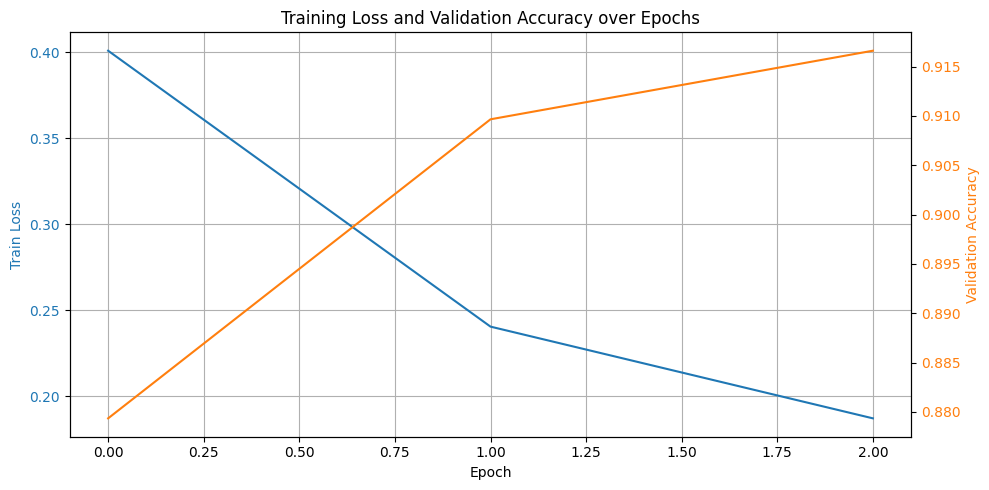

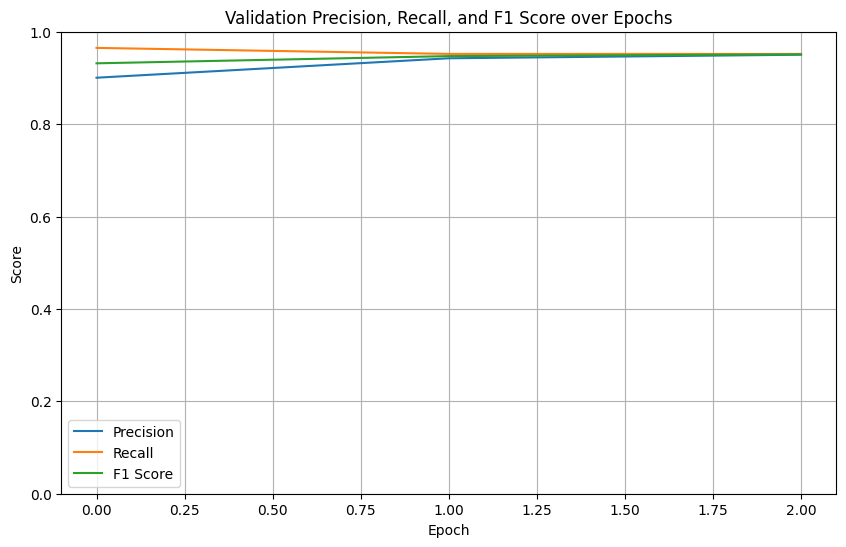

In [45]:

#PLOT TRAINING LOSS AND VALIDATION ACCURACY

fig, ax1 = plt.subplots(figsize=(10,5))

# Plot Training Loss
color = 'tab:blue'
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Train Loss', color=color)
ax1.plot(train_losses, label='Train Loss', color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.grid()

# Create a second y-axis for Validation Accuracy
ax2 = ax1.twinx()  # instantiate a second axes sharing the same x-axis

color = 'tab:orange'
ax2.set_ylabel('Validation Accuracy', color=color)
ax2.plot(val_accuracies, label='Validation Accuracy', color=color)
ax2.tick_params(axis='y', labelcolor=color)

# Titles
plt.title('Training Loss and Validation Accuracy over Epochs')
fig.tight_layout()
plt.show()


#PLOT PRECISION, RECALL, F1 SCORE

plt.figure(figsize=(10,6))

plt.plot(val_precisions, label='Precision')
plt.plot(val_recalls, label='Recall')
plt.plot(val_f1s, label='F1 Score')

plt.title('Validation Precision, Recall, and F1 Score over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Score')
plt.ylim(0, 1)
plt.legend()
plt.grid()
plt.show()


# As we can see, the model performs very well even starting at Epoch 1. Its validation accuracy on average rises from around 0.85 to 0.90 over the course of its training, and all 3 precision, recall, and F1 scores converge at around 0.95.